# Exercises 1

## Tutorial and Exercises

We will look at some basic tabular methods for reinforcement learning in this tutorial, such as value prediction using Monte-Carlo and TD methods and the SARSA and Q-Learning control algorithms

We will use the gym environment from OpenAI. This needs to be installed first.

In [20]:
!pip install gymnasium


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [21]:
import numpy as np
import math
import matplotlib.pyplot as plt

# progress bar, see https://github.com/tqdm/tqdm
import tqdm
import time


import gymnasium as gym

import sys

sys.path.append('.')
from mdp import MDPGridworld, max_arg_with_ties, plot_policy_values
from mdp_env import MDPEnv


## Envs and gridworld

We use an implementation of a gridworld, which in turn is implemented as a markov decision process (MDP). The dark blue state is a terminal state and we use the light green state as starting state. The 4 possible actions are N,E,S and W, if a wall is hit, the agent stays on the current cell. All actions have a reward of -1.

The image shows the state ids which will be obtained from the environment.

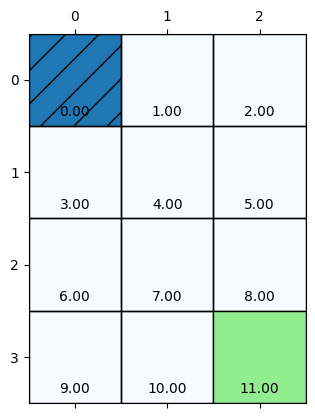

In [22]:
gw = MDPGridworld(height=4, width=3)
gw.state(0,0).is_terminal = True
gw.state(3,2).color = 'lightgreen'

fig, ax = plt.subplots()
gw.render(gw.all_state_ids(), ax)

## Open AI gym (now farama gymnasium)
In order to make algorithms work with any environment, OpenAI has designed a gym.Env class, which defines the environment for any simulation. This has been extended and taken over by farama, who maintain the open source reinforcement learning tools

https://gymnasium.farama.org/index.html

https://gymnasium.farama.org/api/env/

It allows to step through the environment by specifying an action and returns the observation and reward of the step, as well as a bool if a terminal state has been reached and a bool if the episode should be truncated.

Our gridworld is wrapped in the gym environment. The observation returned by the environment is the state id where the agent is after performing an action.

## Monte Carlo (MC) Prediction

We will first see how we can solve MC perdiction. Given a policy, we want to calculate the action-value function for all state/action pairs.

With MC, this means we step through the environment until we reach the end of an episode (a terminal state). Then we calculate the return for each visited state/action pair.

In [23]:
def monte_carlo_prediction(action_space, state_space,
                           policy: np.ndarray,
                           gamma: float,
                           num_repetitions: int) -> np.ndarray:
    """
    Estimate the value function for the environment for the given policy p
    Args:
        action_space: the action space of the environment
        state_space: the state space of the environment
        policy: the policy to evaluate
        gamma: the discount factor
        num_repetitions: The number of repetitions for training

    Returns:
        the state-value function for the policy
    """
    # we keep all returns for a state/action pair and initialize them to an empty list so that we can
    # calculate the averages (we could also do the implementation incrementally)
    nr_actions = action_space.n
    returns = np.empty((state_space.n, nr_actions), dtype=object)
    for s_id in range(state_space.n):
        for a in range(action_space.n):
            returns[s_id, a] = []

    for _ in range(num_repetitions):
        # generate a full episode and add the states and rewards
        states = []
        rewards = []
        actions = []

        obs, _ = env.reset()
        states.append(obs)
        action = np.random.choice(policy.shape[1], p=policy[obs, :])
        actions.append(action)

        while True:
            obs, reward, done, _, _ = env.step(action)
            rewards.append(reward)

            if done:
                break

            states.append(obs)
            action = np.random.choice(policy.shape[1], p=policy[obs, :])
            actions.append(action)

        # calculate the returns for each visited state/action (Q-Function)
        g = 0.0
        for step in reversed(range(len(states))):
            s = states[step]
            a = actions[step]
            r = rewards[step]
            g = gamma * g + r

            # check that s/a does not appear in rest of sequence (first visit MC)
            found = False
            step_seq = step - 1
            while not found and step_seq >= 0:
                found = (states[step_seq] == s) and (actions[step_seq] == a)
                step_seq -= 1

            if not found:
                returns[s, a].append(g)

        # end of episode processing
    # end of number of episodes

    # it is sufficient here to calculate q at the end, as we do not use it in the algorithm
    q = np.zeros(returns.shape)
    # calculate q as mean value of all returns at each state

    for s_id in range(state_space.n):
        for a in range(nr_actions):
            # check for empty list
            if returns[s_id, a]:
                q[s_id, a] = np.mean(returns[s_id, a])
            else:
                # for illustration
                q[s_id, a] = -10000
    return q

The policy needs to be given as a probability for each action. We will evaluate a random policy first.

In [24]:
env = MDPEnv(gw.states, gw.NR_ACTIONS, 11)

# random policy
p = np.zeros((len(gw.states), gw.NR_ACTIONS))
p.fill(1.0/gw.NR_ACTIONS)

In [25]:
np.random.seed(1)
q = monte_carlo_prediction(env.action_space, env.observation_space, p, 1.0, 1000)
print(q)

[[-1.00000000e+04 -1.00000000e+04 -1.00000000e+04 -1.00000000e+04]
 [-2.22771536e+01 -3.36428571e+01 -3.17659574e+01 -1.00000000e+00]
 [-3.09501779e+01 -3.07216117e+01 -3.82662722e+01 -2.20534351e+01]
 [-1.00000000e+00 -2.92619718e+01 -3.37383178e+01 -2.32135231e+01]
 [-2.26213152e+01 -3.44812030e+01 -3.88581907e+01 -2.24371002e+01]
 [-3.05000000e+01 -3.57091837e+01 -4.13539604e+01 -2.92112676e+01]
 [-2.21981308e+01 -3.70491453e+01 -3.91612150e+01 -3.44145729e+01]
 [-3.19838129e+01 -3.92560748e+01 -4.19775051e+01 -3.48074766e+01]
 [-3.38743961e+01 -3.93431953e+01 -4.33881453e+01 -3.75813953e+01]
 [-3.45150943e+01 -4.14589474e+01 -3.91702638e+01 -3.95922078e+01]
 [-3.76715928e+01 -4.18915009e+01 -4.02750491e+01 -3.96648936e+01]
 [-3.92432083e+01 -4.24306452e+01 -4.25479675e+01 -4.03036649e+01]]


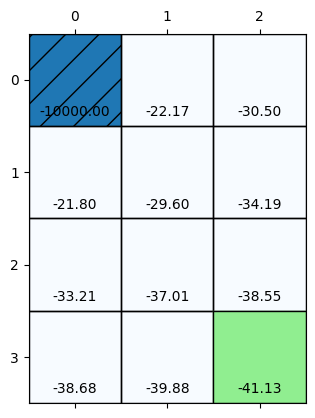

In [26]:
fig, ax = plt.subplots()
gw.render(q.sum(axis=1)/4,ax)

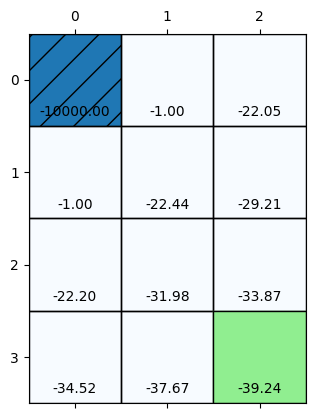

In [27]:
fig, ax = plt.subplots()
gw.render(q.max(axis=1),ax)

### Policy Improvement

We can now get a better policy by taking the greedy actions with respect to the found q function.

In [28]:
def greedy_from_action_values(q) -> np.ndarray:
    """
    Calculate a greedy policy from the action values.
    Args:
        q: the action values
    Returns:
        the greedy policy

    """
    p = np.zeros(q.shape)
    best_action = q.argmax(axis=1)
    for a in range(q.shape[1]):
        p[:, a] = (best_action == a).astype(float)
    return p

In [29]:
p_greedy = greedy_from_action_values(q)
print(p_greedy)

[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


## Policy Iteration

Using the new policy, we can again estimate the q function.

(In practice we will need to do a policy that does some exploring, otherwise we will not visit all state/actions pairs, see result below)



[[-1.e+04 -1.e+04 -1.e+04 -1.e+04]
 [-1.e+04 -1.e+04 -1.e+04 -1.e+04]
 [-1.e+04 -1.e+04 -1.e+04 -1.e+04]
 [-1.e+00 -1.e+04 -1.e+04 -1.e+04]
 [-1.e+04 -1.e+04 -1.e+04 -2.e+00]
 [-1.e+04 -1.e+04 -1.e+04 -3.e+00]
 [-1.e+04 -1.e+04 -1.e+04 -1.e+04]
 [-1.e+04 -1.e+04 -1.e+04 -1.e+04]
 [-4.e+00 -1.e+04 -1.e+04 -1.e+04]
 [-1.e+04 -1.e+04 -1.e+04 -1.e+04]
 [-1.e+04 -1.e+04 -1.e+04 -1.e+04]
 [-5.e+00 -1.e+04 -1.e+04 -1.e+04]]


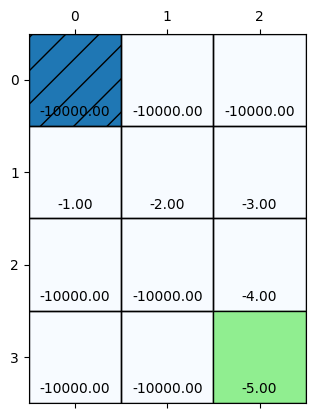

In [30]:
q = monte_carlo_prediction(env.action_space, env.observation_space, p_greedy, 1.0, 1000)
print(q)
fig, ax = plt.subplots()
gw.render(q.max(axis=1),ax)

## TD Prediction

Instead of the MC algorithm, we would like to use the time difference (TD) algorithm now to calculate the prediction. This has the advantage of updating the q values right away and generally converges faster to the correct values.

In [31]:
def td_prediction(action_space, state_space,
                  policy: np.ndarray,
                  gamma: float,
                  step_size: float,
                  num_repetitions: int) -> np.ndarray:
    """
    Estimate the value function for the environment for the given policy p
    Args:
        action_space: the action space of the environment
        state_space: the state space of the environment
        policy: the policy to evaluate
        gamma: the discount factor
        num_repetitions: The number of repetitions for training

    Returns:
        the state-value function for the policy
    """
    # we directly keep the q values
    q = np.zeros((state_space.n, action_space.n))

    for _ in range(num_repetitions):
        # initialize episode
        obs, _ = env.reset()

        # our observations are the state ids
        state_id = obs
        action = np.random.choice(policy.shape[1], p=policy[obs, :])

        done = False
        while not done:
            last_state_id = state_id
            last_action = action

            # get reward and next state (observation) from the action
            obs, reward, done, _, _ = env.step(action)
            state_id = obs

            # get the next action (needed to update q values)
            action = np.random.choice(policy.shape[1], p=policy[obs, :])

            if not done:
                delta = reward + \
                    gamma * q[state_id, action] - \
                    q[last_state_id, last_action]
                q[last_state_id, last_action] += step_size * delta
            else:
                # terminal state reached, we still need to update the last q value
                delta = reward - q[last_state_id, last_action]
                q[last_state_id, last_action] += step_size * delta
                break
    return q

[[  0.           0.           0.           0.        ]
 [-13.32259057 -27.99507277 -25.81154642  -1.        ]
 [-29.86587661 -27.29775599 -30.57034471 -20.51824582]
 [ -1.         -27.90283484 -32.99029697 -17.30923357]
 [-15.16431608 -31.20615022 -30.20664459 -21.18333051]
 [-28.95142809 -29.98171418 -33.72410795 -24.39805334]
 [-19.16672716 -31.34084229 -36.43290227 -32.71368064]
 [-26.28177974 -35.24768117 -37.62954236 -30.91005722]
 [-29.53336734 -35.83350055 -38.2108591  -31.3100452 ]
 [-30.90222621 -36.60721612 -36.44362282 -35.0462491 ]
 [-33.91693767 -38.35031484 -37.37699957 -36.15947379]
 [-34.22236449 -37.77264868 -37.82039224 -36.82635184]]


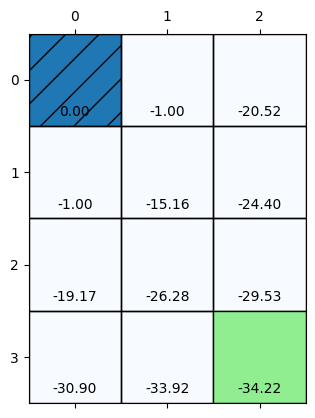

In [32]:
np.random.seed(1)
# random policy
p = np.zeros((len(gw.states), gw.NR_ACTIONS))
p.fill(1.0/gw.NR_ACTIONS)
q = td_prediction(env.action_space, env.observation_space, p, 1.0, 0.1, 1000)
print(q)
fig, ax = plt.subplots()
gw.render(q.max(axis=1),ax)

## Agent Implementation

Next, we want to implement control algorithms that calculate the action-value function q and select a policy according to the current q function. This will result in better policies over time and ultimately calculate the optimal policy.

We will use an Agent base class to be able to implement different control algorithms.

In [33]:
class Agent:
    """
    Class for an agent in our env.
    """

    def __init__(self, action_space, state_space):
        self._action_space = action_space
        self._state_space = state_space

    def reset(self) -> (int, int):
        """
        Reset the learning of the agent to an initial condition, so it can be used again, for example to
        compare different runs.
        """
        raise NotImplementedError

    def step(self, observation, reward: float, done: bool):
        """
        Step in the environment. The reward given is the returned reward from the last action, if it is None, then this is the first step in the environment
        Args:
            observation: the current position of the agent
            reward: the reward obtained from the last action
            done: the done returned from the last action on the environment (signals the end of an episode)
        Returns:
            the action
        """
        raise NotImplementedError

    def train(self, env: gym.Env, nr_episodes: int):
        """
        Train the agent in the given environment
        Args:
            env: the env to train the agent on
            nr_episodes: number of episodes to train.
        """
        raise NotImplementedError

## SARSA Agent

First, we implement a SARSA agent. This calculates the q-values in the same way than in the prediction above. It uses a epsilon-greedy policy for choosing the actions.

In [34]:
class SarsaAgent(Agent):
    """
    Sarsa Agent
    """
    def __init__(self, action_space, state_space, gamma: float, step_size: float, epsilon: float):
        """
        Initialize Sarsa

        Args:
            action_space: the action space
            state_space: the state space
            gamma: the discount factor
            step_size: the step size for the update
            epsilon: the epsilon for the epsilon greedy policy
        """
        super().__init__(action_space, state_space)
        self._epsilon = epsilon
        self._gamma = gamma
        self._step_size = step_size

        # We want to estimate the state-action value function
        self._q = np.zeros((state_space.n, self._action_space.n))

        # we need to remember the last state and action
        self._last_state_id = None
        self._last_action = None

    @property
    def q(self):
        return self._q

    def reset(self):
        """
        Reset the learning of the agent to an initial condition, so it can be used in a new env.
        """
        self._q.fill(0.0)

    def get_eps_greedy_action(self, state) -> int:
        """
        Helper function to get the epsilon greedy action from the indicated state as we do
        not need to specify a policy explicitely. Use max_arg_with_ties for the greedy case, which is a
        helper function that randomly selects an action in case of a tie

        Return the taken action.
        """
        if np.random.random() < self._epsilon:
            action = np.random.randint(self._action_space.n)
        else:
            action = max_arg_with_ties(self._q[state, :])
        return action

    def step(self, observation, reward, done) -> int or None:
        """
        Step in the environment. The reward is the returned reward from the last action and the
        observation contains the state after performing the last action.
        Args:
            observation: the observation from the environment (here the state_id)
            reward: the reward from the last action
            done: true if the episode is finished as a terminal state has been reached
        Returns:
            the action to take next or None if the episode is finished
        """
        # During the episodes you will need to
        # - determine the next action
        # - update the action-state estimates
        # - save the state and action
        # - return the action

        state_id = observation

        # select the next action
        action = self.get_eps_greedy_action(state_id)

        # first step in the environment, where we did not get a reward yet, we just need to remember the values
        # and return the action
        if not reward:
            self._last_state_id = state_id
            self._last_action = action
            return action

        if not done:

            # update q from last action
            # calculate error term first
            delta = reward + \
                    self._gamma * self._q[state_id, action] - \
                    self._q[self._last_state_id, self._last_action]

            self._q[self._last_state_id, self._last_action] += self._step_size * delta

            self._last_state_id = state_id
            self._last_action = action

            return action
        else:
            # episode is done, but we still need to calculate the last update,

            # all action values from the terminal state are considered zero

            delta = reward - self._q[self._last_state_id, self._last_action]
            self._q[self._last_state_id, self._last_action] += self._step_size * delta

            # we return None as there is no action from a terminal state
            return None

    def train(self, env, nr_episodes):
        for _ in range(nr_episodes):
            obs, _ = env.reset()
            a = self.step(obs, None, False)
            done = False
            while not done:
                obs, reward, done, _, _ = env.step(a)
                a = self.step(obs, reward, done)

In [35]:
env = MDPEnv(gw.states, gw.NR_ACTIONS, 11)
agent = SarsaAgent(env.action_space, env.observation_space, gamma=1.0, step_size=0.05, epsilon=0.05)
agent.reset()


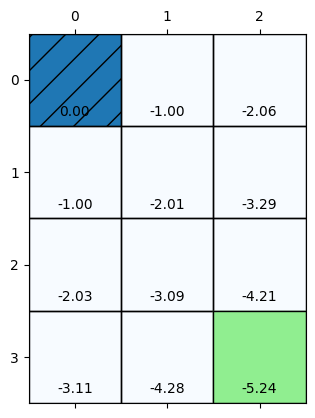

In [36]:
agent.train(env, 10000)
fig, ax = plt.subplots()
gw.render(agent.q.max(axis=1),ax)

## Q-Learning Agent

The implementation of the q-learning agent is left as an exercise :-). You will have to implement the step function, the other functions are the same as in SARSA.

In [37]:
class QLearningAgent(Agent):
    """
    Q-Learning Agent
    """

    def __init__(self, action_space, state_space, gamma: float, step_size: float, epsilon: float):
        """
        Args:
            action_space: the action space
            state_space: the state space
            gamma: the discount factor
            step_size: the step size for the update
            epsilon: the epsilon for the epsilon greedy policy
        """
        super().__init__(action_space, state_space)
        self._epsilon = epsilon
        self._gamma = gamma
        self._step_size = step_size

        # We want to estimate the state-action value function
        self._q = np.zeros((state_space.n, self._action_space.n))

        # we need to remember the last state and action
        self._last_state_id = None
        self._last_action = None

    @property
    def q(self):
        return self._q

    def reset(self):
        """
        Reset the learning of the agent to an initial condition, so it can be used in a new env.
        """
        self._q.fill(0.0)

    def get_eps_greedy_action(self, state):
        """
        Helper function to get the epsilon greedy action from the indicated state
        """

        # this is the same as in SARSA

        ### BEGIN SOLUTION
        if np.random.random() < self._epsilon:
            action = np.random.randint(self._action_space.n)
        else:
            action = max_arg_with_ties(self._q[state, :])
        return action
        ### END SOLUTION


    def step(self, observation, reward, done) -> int or None:
        """
        Step in the environment. The reward is the returned reward from the last action or None if that was the first step
        """
        state_id = observation

        # select the next action
        action = self.get_eps_greedy_action(state_id)

        # first step in the environment, where we did not get a reward yet, we just need to remember the values
        # and return the action
        if not reward:
            self._last_state_id = state_id
            self._last_action = action
            return action

        if not done:

            # update q from last action
            # calculate error term first
            delta = reward + \
                    self._gamma * self._q[state_id, action] - \
                    self._q[self._last_state_id, self._last_action]

            self._q[self._last_state_id, self._last_action] += self._step_size * delta

            self._last_state_id = state_id
            self._last_action = action

            return action
        else:
            # episode is done, but we still need to calculate the last update,

            # all action values from the terminal state are considered zero

            delta = reward - self._q[self._last_state_id, self._last_action]
            self._q[self._last_state_id, self._last_action] += self._step_size * delta

            # we return None as there is no action from a terminal state
            return None
        

    def train(self, env, nr_episodes):
        for e in range(nr_episodes):
            obs, _ = env.reset()
            a = self.step(obs, None, False)
            done = False
            while not done:
                obs, reward, done, _, _ = env.step(a)
                a = self.step(obs, reward, done)

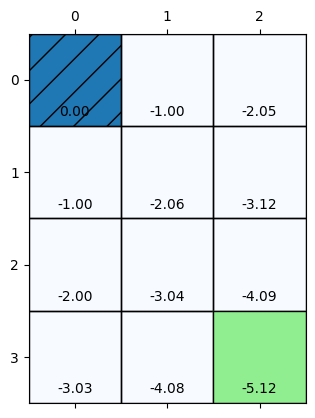

In [38]:
env = MDPEnv(gw.states, gw.NR_ACTIONS, 11)
agent = QLearningAgent(env.action_space, env.observation_space, gamma=1.0, step_size=0.05, epsilon=0.05)
agent.reset()
agent.train(env, 10000)
fig, ax = plt.subplots()
gw.render(agent.q.max(axis=1),ax)

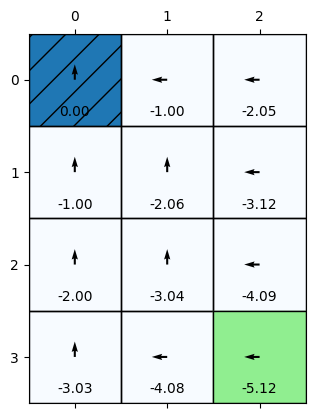

In [39]:
p_greedy = greedy_from_action_values(agent.q)
plot_policy_values(p_greedy, agent.q.max(axis=1), gw)